Working with data from the World Bank, this analysis uses SQL, pandas and matplotlib in Jupyter Notebooks to understand how global CO2 emissions changed between 1960 and 2011. 

The dataset includes two tables, one with data on countries' gross annual CO2 emissions, and one with per capita CO2 emissions. We also have data on each country's region and income status.

Using this data, we can see how we have continued to increase CO2 emissions into the atmosphere. We can also identify the most polluting countries and regions, and see which countries have experienced the greatest changes in their CO2 emissions between 1960 and 2011. 

The original dataset can be downloaded [here](https://mkt.tableau.com/Public/Datasets/World_Bank_CO2.xlsx).

## Set up

### Define functions

In [1]:
#@title
import tempfile
from urllib import request
import sqlite3

from typing import Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

#%load_ext google.colab.data_table

# Set float display options for pandas dataframes.
pd.options.display.float_format = "{:,.2f}".format

def excel_dataset_to_sqlite(url: str, database_name: str = ":memory:") -> sqlite3.Connection:
  """Downloads an excel dataset and loads it into an sqlite database."""

  # Download the data into a local variable.
  data = request.urlopen(url).read()

  # Write it out to afiles
  with tempfile.TemporaryFile() as fle:
    fle.write(data)

    # Read into pandas from excel file.
    data = pd.read_excel(fle, sheet_name=None)

  # Create a database.
  conn = sqlite3.connect(database_name)

  # Loads data from pandas objects into individual tables.
  for (key, sheet) in data.items():
    sheet = sheet.where(pd.notnull(sheet), None)
    sheet.to_sql(key, conn)


  # Return database.
  return conn

### Prepare the data

#### Import the dataset and create the database

The data comes from the World Bank and is an Excel file containing 9 worksheets. 

I download the file from [this URL](https://mkt.tableau.com/Public/Datasets/World_Bank_CO2.xlsx), and convert it into an SQL database to enable analysis in Jupyter Notebooks.

In [2]:
database = excel_dataset_to_sqlite(
    "https://mkt.tableau.com/Public/Datasets/World_Bank_CO2.xlsx")

/Users/Matthew/Library/Caches/pypoetry/virtualenvs/notebooks-IW0Gw3EE-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


Once the database has been created, I change the names of some of the tables and columns to make the data easier to work with

In [3]:
#@title
database.execute("""ALTER TABLE `CO2 (kt) for Split` 
               RENAME TO CO2_kt;""")

database.execute("""ALTER TABLE `CO2 Data Cleaned` 
               RENAME TO CO2_Data_Cleaned;""")

database.execute("""ALTER TABLE `CO2 Per Capita (Pivoted)` 
               RENAME TO CO2_Per_Capita;""")

database.execute("""ALTER TABLE `Metadata - Countries` 
               RENAME TO Metadata_Countries;""")

In [4]:
#@title
database.execute("""ALTER TABLE CO2_kt
               RENAME COLUMN `CO2 (kt)` TO CO2_kt;""")

database.execute("""ALTER TABLE CO2_kt
               RENAME COLUMN `Country Name` TO Country_Name;""")

database.execute("""ALTER TABLE CO2_Per_Capita
               RENAME COLUMN `CO2 Per Capita (metric tons)` TO CO2_Per_Capita;""")

database.execute("""ALTER TABLE CO2_Per_Capita
               RENAME COLUMN `Country Name` TO Country_Name;""")

## Understand the data


### What do the tables look like?

There are two tables which are interesting for this analysis: CO2_kt and CO2_Per_Capita.

The first table, CO2_kt, has 5 columns showing CO2 emissions per country for the years 1960-2011.

In [5]:
result = pd.read_sql("""SELECT *
                        FROM CO2_kt
                        LIMIT 10
                        OFFSET 100;""", database)
result

,index,Country Code,Country_Name,Region,Year,CO2_kt
0,100,AND,Andorra,Europe & Central Asia,2008,539.05
1,101,AND,Andorra,Europe & Central Asia,2009,517.05
2,102,AND,Andorra,Europe & Central Asia,2010,517.05
3,103,AND,Andorra,Europe & Central Asia,2011,491.38
4,104,AFG,Afghanistan,South Asia,1960,414.37
5,105,AFG,Afghanistan,South Asia,1961,491.38
6,106,AFG,Afghanistan,South Asia,1962,689.40
7,107,AFG,Afghanistan,South Asia,1963,707.73
8,108,AFG,Afghanistan,South Asia,1964,839.74
9,109,AFG,Afghanistan,South Asia,1965,"1,008.42"



The second table, CO2_Per_Capita, is very similar, although the columns are ordered differently, and there is no 'Region' column.

In [6]:
result = pd.read_sql("""SELECT Country_Name,
                               `Country Code`,
                               Year,
                               CO2_Per_Capita
                        FROM CO2_Per_Capita
                        LIMIT 10
                        OFFSET 100;""", database)
result

,Country_Name,Country Code,Year,CO2_Per_Capita
0,Afghanistan,AFG,2008,0.16
1,Afghanistan,AFG,2009,0.25
2,Afghanistan,AFG,2010,0.30
3,Afghanistan,AFG,2011,0.43
4,Angola,AGO,1960,0.10
5,Angola,AGO,1961,0.08
6,Angola,AGO,1962,0.22
7,Angola,AGO,1963,0.21
8,Angola,AGO,1964,0.22
9,Angola,AGO,1965,0.21


### How complete is the data?

The data is not complete, and we can see this by looking at it on a per year and per country basis.

#### Data by year

A total of 214 countries are mentioned in the data. No year has data for all 214 countries.

We can see that the data for earlier years are less complete than for later years. Approximately 150 countries feature in the data for 1960; this rises to approximately 200 for 2011. 


In [7]:
result = pd.read_sql(
"""SELECT Year, 
          COUNT(CO2_kt), 
          COUNT(DISTINCT Country_Name) as number_data_points
FROM CO2_kt
GROUP BY year;""", database)

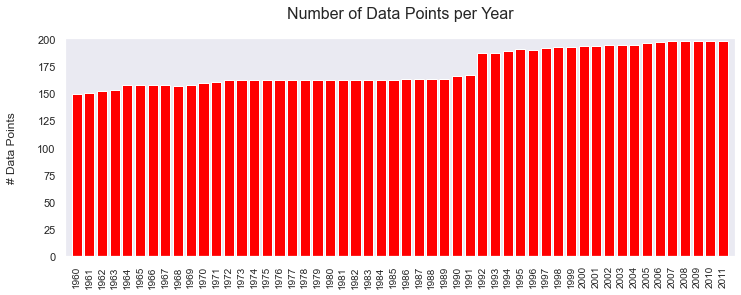

In [8]:
plt.figure(figsize=(12, 4))
plt.grid(False)
plt.bar(x=result["Year"].astype(str), height=result["COUNT(CO2_kt)"], color='red')
plt.title("Number of Data Points per Year", fontsize = 16, pad = 20)
plt.ylabel("# Data Points", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 90, ha = "center", fontsize = 10)
plt.margins(0.01, 0.01)

#### Data by country

There are also gaps when we look at the data on a per-country basis, although the data seem more complete than on a per-year basis. 

The data cover 52 years from 1960-2011. 147 of the 214 countries (69%) in the dataset have data for every one of these years. 

For 15 countries, there is no data. The remainder have between 5 and 51 data points.

In [9]:
result = pd.read_sql(
"""WITH data_point AS (SELECT Country_Name, 
                       SUM(CO2_kt IS NOT NULL) AS data_points
                       FROM CO2_kt
                       GROUP BY Country_Name)
                              
SELECT DISTINCT(data_points), 
       COUNT(*)
FROM data_point
GROUP BY data_points
ORDER BY data_points ASC;""", database)


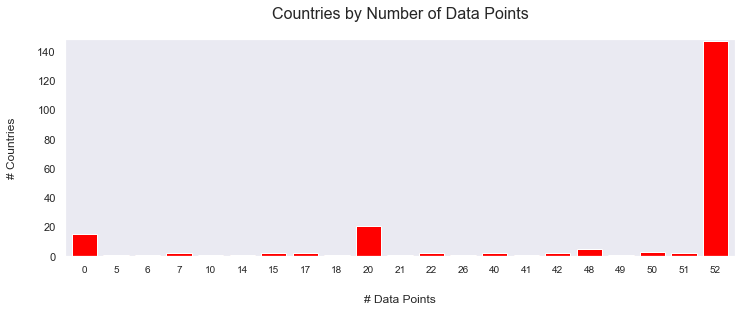

In [10]:
plt.figure(figsize=(12, 4))
plt.grid(False)
plt.bar(x=result["data_points"].astype(str), height=result["COUNT(*)"], color='red')
plt.title("Countries by Number of Data Points", pad = 20, fontsize = 16)
plt.xlabel("# Data Points", labelpad=20, fontsize = 12)
plt.ylabel("# Countries", labelpad=20, fontsize = 12)
_ = plt.xticks(ha = "center", fontsize = 10)
plt.margins(0.01, 0.01)

## Annual emissions have been increasing consistently since 1960

The emissions figures show that there has been a consistent upward trend in CO2 emissions since 2011, although there have been year-on-year decreases, for instance between 1979 and 1980, or 2008 and 2009.

In [11]:
result = pd.read_sql("""SELECT year, SUM(CO2_kt) as sum_of_year, 
                        AVG(SUM(CO2_kt)) OVER() as avg_sum
                        FROM CO2_kt
                        GROUP BY year;""", database)


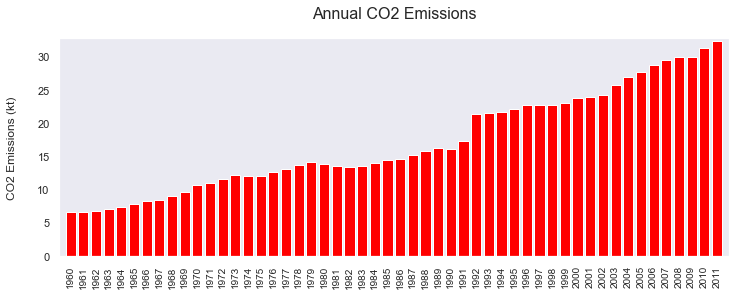

In [12]:
plt.figure(figsize=(12, 4))
plt.grid(False)
plt.bar(x=result["Year"].astype(str), height=result["sum_of_year"] / 1000000, color='red')
plt.title("Annual CO2 Emissions", pad = 20, fontsize = 16)
plt.ylabel("CO2 Emissions (kt)", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 90, ha = "center", fontsize = 10)
plt.margins(0.01, 0.01)

## Regions with the highest emissions

Annual emissions have increased across all regions since 1960. North America was the leading emitter in 1960, but has been overtaken by East Asia & Pacific, where emissions have grown almost twelve-fold in the period, and Europe & Central Asia.

In [13]:
result = pd.read_sql("""SELECT region, year, SUM(CO2_kt) 
                        FROM CO2_kt
                        WHERE year = 1960 OR year = 2011
                        GROUP BY region, year;""", database)


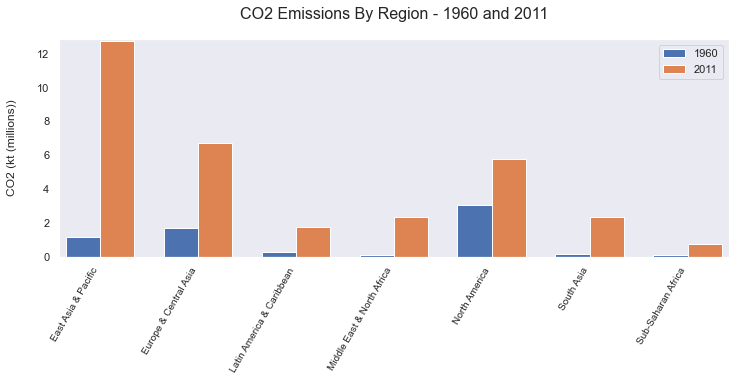

In [14]:
subset_1960 = result[result["Year"] == 1960]
subset_2011 = result[result["Year"] == 2011]

x_1960 = np.arange(len(subset_1960["Region"]))
x_2011 = np.arange(len(subset_2011["Region"]))

y_1960 = subset_1960["SUM(CO2_kt)"] / 1_000_000
y_2011 = subset_2011["SUM(CO2_kt)"] / 1_000_000
width = 0.35
fig, ax = plt.subplots(figsize=(12, 4))
rects1 = ax.bar(x_1960 - width/2, y_1960, width, label="1960")
rects2 = ax.bar(x_2011 + width/2, y_2011, width, label='2011')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('CO2 (kt (millions))', fontsize = 12)
ax.yaxis.labelpad = 20
#ax.set_xlabel('Region')
ax.xaxis.labelpad = 20

ax.set_title('CO2 Emissions By Region - 1960 and 2011', pad=20, fontsize = 16)
ax.set_xticks(x_1960)
ax.set_xticklabels(subset_1960["Region"])
ax.xaxis.labelpad = 20
ax.legend()
_ = plt.xticks(rotation = 60, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)
plt.grid(False)
plt.show()

## Countries with the highest CO2 emissions 1960-2011

This chart shows the 20 countries with the highest cumulative emissions in the period covered. 

The US was the largest producer of CO2 in this period. The other countries in the top 20 are mainly from Europe, East Asia & Pacific, or North America.

In [15]:
result = pd.read_sql("""SELECT Country_Name, Region, SUM(CO2_kt) 
                        FROM CO2_kt
                        GROUP BY Country_Name
                        ORDER BY SUM(CO2_kt) DESC
                        LIMIT 20;""", database)



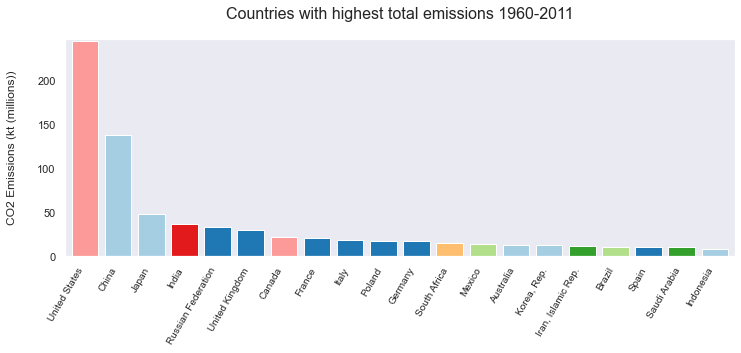

In [16]:
plt.figure(figsize=(12, 4))
plt.grid(False)
palette = iter(sns.color_palette('Paired'))
colour_map = {region_name: next(palette) 
              for region_name in np.unique(result["Region"])}
colours = [colour_map.get(x, "green") for x in result["Region"]]
regions = [region for region in result["Region"]]
plt.bar(x=result["Country_Name"], height=result["SUM(CO2_kt)"] / 1000000, color=colours)
plt.title("Countries with highest total emissions 1960-2011", fontsize = 16, pad = 20)
plt.ylabel("CO2 Emissions (kt (millions))", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 60, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)


## Countries with the largest increase in emissions between 1960 and 2011

Global CO2 emissions have increased over the period, but where have they increased the most?

China has seen the greatest increase in emissions. China's annual emissions were more than eight million kt higher in 2011 than in 1960. 

In [17]:
result = pd.read_sql(
"""WITH first_emissions AS 
       (SELECT DISTINCT Country_Name,
        FIRST_VALUE(Year) OVER (PARTITION BY Country_Name ORDER BY year ASC) as initial_year,
        FIRST_VALUE(CO2_kt) OVER (PARTITION BY Country_Name ORDER BY year ASC) as initial_emissions
        FROM CO2_kt
        WHERE CO2_kt IS NOT NULL)

SELECT CO2_kt.Country_Name, 
       first_emissions.initial_year,
       first_emissions.initial_emissions,
       Year,
       CO2_kt,
       Region,
      (CO2_kt - first_emissions.initial_emissions) AS increase_in_emissions                               
FROM CO2_kt
INNER JOIN first_emissions ON CO2_kt.Country_Name = first_emissions.Country_Name
WHERE CO2_kt IS NOT NULL
AND Year = 2011
ORDER BY increase_in_emissions DESC
LIMIT 20;""", database)

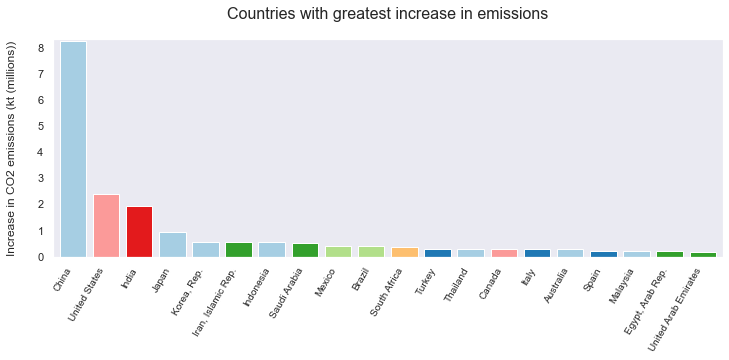

In [18]:
plt.figure(figsize=(12, 4))
plt.grid(False)
palette = iter(sns.color_palette('Paired'))
colour_map = {region_name: next(palette) 
              for region_name in np.unique(result["Region"])}
colours = [colour_map.get(x, "green") for x in result["Region"]]
regions = [region for region in result["Region"]]
plt.bar(x=result["Country_Name"], height=result["increase_in_emissions"] / 1000000, color=colours, align = 'center')
plt.title("Countries with greatest increase in emissions", fontsize = 16, pad = 20)
plt.ylabel("Increase in CO2 emissions (kt (millions))", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 60, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)


## Countries with the biggest decreases in CO2 emissions

Despite the global increase in emissions during the period, some countries have seen reductions in the amount of CO2 they are producing. 

Ukraine and Russia have seen the biggest reductions in CO2 emissions, followed by Germany and the UK. 

While it's positive to see some countries have reduced their CO2 emissions, it's worth noting that the size of these reductions is far smaller than the size of the increases generated by other countries. For example, Russia's emissions are down 350,000 kt, but China's have increased by more than 8,000,000 kt.

In [19]:
result = pd.read_sql(
"""WITH first_emissions AS 
   (SELECT DISTINCT Country_Name,
    FIRST_VALUE(Year) OVER (PARTITION BY Country_Name ORDER BY year ASC) as initial_year,
    FIRST_VALUE(CO2_kt) OVER (PARTITION BY Country_Name ORDER BY year ASC) as initial_emissions
    FROM CO2_kt
    WHERE CO2_kt IS NOT NULL)

SELECT CO2_kt.Country_Name, 
       first_emissions.initial_year,
       first_emissions.initial_emissions,
       Year,
       CO2_kt,
       Region,
      (CO2_kt - first_emissions.initial_emissions) AS increase_in_emissions                               
FROM CO2_kt
INNER JOIN first_emissions ON CO2_kt.Country_Name = first_emissions.Country_Name
WHERE CO2_kt IS NOT NULL
AND Year = 2011
ORDER BY increase_in_emissions ASC
LIMIT 20;""", database)

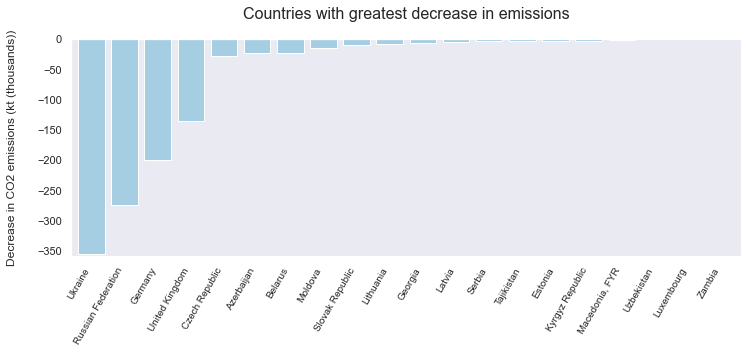

In [20]:
plt.figure(figsize=(12, 4))
plt.grid(False)
palette = iter(sns.color_palette('Paired'))
colour_map = {region_name: next(palette) 
              for region_name in np.unique(result["Region"])}
colours = [colour_map.get(x, "green") for x in result["Region"]]
regions = [region for region in result["Region"]]
plt.bar(x=result["Country_Name"], height=result["increase_in_emissions"] / 1000, color=colours, align = 'center')
plt.title("Countries with greatest decrease in emissions", pad = 20, fontsize = 16)
plt.ylabel("Decrease in CO2 emissions (kt (thousands))", labelpad = 20, fontsize = 12)
_ = plt.xticks(rotation = 60, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## The US' CO2 emissions over time

What do the data say about individual countries? Let's look at the US' CO2 emissions over the period.

Global CO2 emissions have been on a steady upward trajectory. The same can be said for the US, which produced 2 million kt more CO2 in 2011 than in 1960. However, deviations from this path have been more severe and lasted longer in the US than on the global level. 

Emissions declined sharply between 2008 and 2009 during the financial crisis. Although they rebounded, in 2011 they remained below the 2007 peak. On the global level, there was a less severe reduction in emissions between 2008 and 2009, and in 2011 emissions were higher than in 2007.

In [21]:
result = pd.read_sql("""
 SELECT CO2_kt.year, CO2_kt, CO2_Per_Capita
 FROM CO2_kt
 LEFT JOIN CO2_Per_Capita ON CO2_kt.year = CO2_Per_Capita.year 
     AND CO2_kt.Country_Name = CO2_Per_Capita.Country_Name
 WHERE CO2_kt.Country_Name = "United States";""", database)

<ipython-input-22-6c0117d8a232>:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=result["Year"].astype(str), y=result["CO2_kt"] / 1_000_000, linestyle = "-", marker = "")


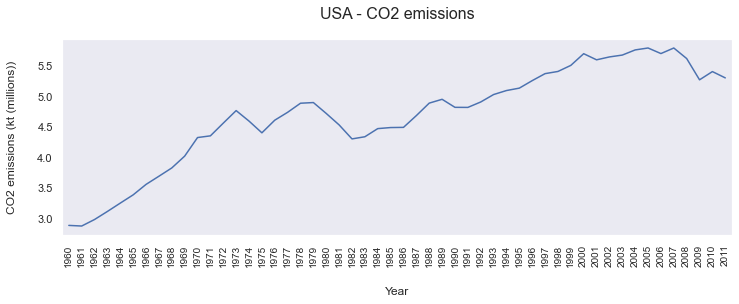

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot_date(x=result["Year"].astype(str), y=result["CO2_kt"] / 1_000_000, linestyle = "-", marker = "")
fig.autofmt_xdate()
plt.grid(False)
plt.title("USA - CO2 emissions", fontsize = 16, pad = 20)
plt.xlabel("Year")
ax.xaxis.labelpad = 20
plt.ylabel("CO2 emissions (kt (millions))", fontsize = 12)
ax.yaxis.labelpad = 20
_ = plt.xticks(rotation = 90, ha = "center", fontsize = 10)
plt.margins(0.01, 0.05)
plt.show()

## USA - gross and per-capita emissions

How do US emissions on the national scale relate to the emissions of individual residents?

This chart shows that the US' emissions have increased since 1960 at both the gross and per-capita level. However, per-capita emissions peaked in 1973, while gross emissions did not peak until 2007. In 2011, gross emissions where 83% higher than in 1960, but per-capita emissions only 6% higher. 

In [25]:
result = pd.read_sql("""
WITH initial_gross AS (SELECT CO2_kt FROM CO2_kt
                       WHERE Country_Name = "United States"
                       ORDER BY year ASC
                       LIMIT 1),

     initial_capita AS (SELECT CO2_Per_Capita FROM CO2_Per_Capita
                        WHERE Country_Name = "United States"
                        ORDER BY year ASC
                        LIMIT 1)                                           

SELECT CO2_kt.year, 
      (CO2_kt.CO2_kt / initial_gross.CO2_kt) * 100 as gross_CO2, 
      (CO2_Per_Capita.CO2_Per_Capita / initial_capita.CO2_Per_Capita) * 100 as capita_CO2
      FROM CO2_kt
      LEFT JOIN CO2_Per_Capita ON CO2_kt.year = CO2_Per_Capita.year 
              AND CO2_kt.Country_Name = CO2_Per_Capita.Country_Name
      INNER JOIN initial_gross
      INNER JOIN initial_capita
      WHERE CO2_kt.Country_Name = "United States";""", database)

<ipython-input-26-17b007b5e674>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(result["Year"].astype(str), fontsize = 10)
<ipython-input-26-17b007b5e674>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


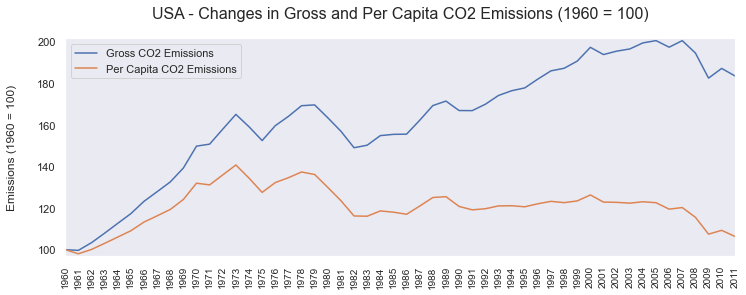

In [26]:
# line 1 points
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.grid(False)
_ = plt.xticks(rotation = 90, ha = "center")
x1 = result["Year"].astype(str)
y1 = result["gross_CO2"]
# plotting the line 1 points 
ax1.plot(x1, y1, label = "Gross CO2 Emissions")
# line 2 points
y2 = result["capita_CO2"]
# plotting the line 2 points 
ax1.plot(x1, y2, label = "Per Capita CO2 Emissions")
ax1.set_xticklabels(result["Year"].astype(str), fontsize = 10)
# Set the y axis label of the current axis.
ax1.set_ylabel('Emissions (1960 = 100)', fontsize = 12)
ax1.yaxis.labelpad = 20
# Set a title of the current axes.
ax1.set_title('USA - Changes in Gross and Per Capita CO2 Emissions (1960 = 100)', pad = 20, fontsize = 16)
# show a legend on the plot
ax1.legend()
ax1.margins(0.0, 0.01)
# Display a figure.
fig.show()

